<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/AE/VAE_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder


## Import and Config

In [14]:
!pip install -q --upgrade albumentations==0.5.1

In [15]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [16]:
IN_HEIGHT, IN_WIDTH = 28, 28

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [25]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class VAE(nn.Module):
    def __init__(self, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=1, z_dim=2):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            Flatten(),
            nn.Linear(in_height * in_width * in_channel, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
            nn.ReLU(),
        )

        self.encoder_mu = nn.Linear(dim, z_dim)
        self.encoder_sigma = nn.Linear(dim, z_dim)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, in_height * in_width * in_channel),
            nn.Tanh(),
            Reshape(in_channel, in_height, in_width)
        )
        
    def forward(self, x):
        mu, sigma = self.forward_encoder(x)
        x = self.forward_sampler(mu, sigma)
        x = self.forward_decoder(x)
        return x, mu, sigma

    def sample_z(self, x):
        mu, sigma = self.forward_encoder(x)
        return self.forward_sampler(mu, sigma)

    def forward_encoder(self, x):
        x = self.encoder(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma

    def forward_sampler(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_decoder(self, x):
        return self.decoder(x)

def loss_KLDivergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Dataset

In [18]:
train_ds = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data.numpy()[..., None].astype(np.float32)
train_ys = np.array(train_ds.targets)

class MnistDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [19]:
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [20]:
def show_sample(Xs, show_num=8, name="input"):
    Xs = Xs.detach().cpu().numpy()[:, 0]
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()

In [28]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_Xs, train_ys, train_ys)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs, train_ys)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    EPOCH = 50
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = MnistDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = MnistDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(dataloader_train)
        val_n = len(dataloader_val)
        target_n = 1
        
        #---
        # model
        #---
        model = VAE()
        model = model.to(device)
        
        criterion = nn.MSELoss(reduction='sum')
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
  
        #---
        # epoch
        #---
        for epoch in range(EPOCH):
            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs, mu, sigma = model(xs)

                loss_recon = criterion(outputs, xs) # loss reconstruction
                loss_kld = loss_KLDivergence(mu, sigma) # loss KLDivergence
                loss = (loss_recon + loss_kld) / len(xs)

                loss.backward()

                tr_loss += loss.item() / train_n
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += 0#(predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs, mu, sigma = model(xs)

                    loss_recon = criterion(outputs, xs) # loss reconstruction
                    loss_kld = loss_KLDivergence(mu, sigma) # loss KLDivergence
                    loss = (loss_recon + loss_kld) / len(xs)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += 0#(predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} [val]loss:{val_loss:.4f} [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

            if (epoch + 1) % 10 == 0:
                show_sample(xs, name="input")
                show_sample(outputs, name="output")

        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()

        
    return train_models, train_model_paths


StratifiedKFold fold:1/2
train_N=30000, val_N=30000
fold:1 epoch:1/50 [tra]loss:276.2501 [val]loss:220.5804 [time]total:5.73sec tra:2.98sec val:2.75sec
fold:1 epoch:2/50 [tra]loss:209.5626 [val]loss:206.4926 [time]total:5.68sec tra:2.94sec val:2.74sec
fold:1 epoch:3/50 [tra]loss:203.0671 [val]loss:203.8114 [time]total:5.34sec tra:2.97sec val:2.37sec
fold:1 epoch:4/50 [tra]loss:201.2561 [val]loss:202.9273 [time]total:5.78sec tra:2.99sec val:2.78sec
fold:1 epoch:5/50 [tra]loss:200.3435 [val]loss:199.9058 [time]total:5.35sec tra:2.97sec val:2.38sec
fold:1 epoch:6/50 [tra]loss:199.5299 [val]loss:199.7230 [time]total:5.87sec tra:3.00sec val:2.86sec
fold:1 epoch:7/50 [tra]loss:198.1247 [val]loss:199.0432 [time]total:5.48sec tra:3.09sec val:2.39sec
fold:1 epoch:8/50 [tra]loss:195.6326 [val]loss:196.1146 [time]total:5.71sec tra:2.98sec val:2.73sec
fold:1 epoch:9/50 [tra]loss:192.5544 [val]loss:191.4150 [time]total:5.31sec tra:2.96sec val:2.35sec
fold:1 epoch:10/50 [tra]loss:188.6058 [val]loss:

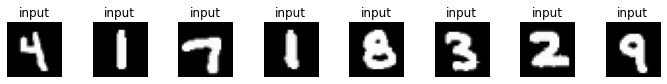

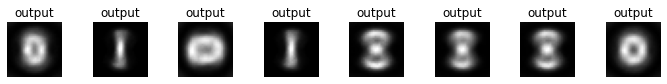

fold:1 epoch:11/50 [tra]loss:186.2132 [val]loss:184.7474 [time]total:5.57sec tra:2.98sec val:2.59sec
fold:1 epoch:12/50 [tra]loss:184.2189 [val]loss:183.8272 [time]total:5.59sec tra:2.96sec val:2.63sec
fold:1 epoch:13/50 [tra]loss:183.4957 [val]loss:182.8789 [time]total:5.45sec tra:2.99sec val:2.46sec
fold:1 epoch:14/50 [tra]loss:183.2225 [val]loss:181.6452 [time]total:5.58sec tra:2.98sec val:2.60sec
fold:1 epoch:15/50 [tra]loss:181.6159 [val]loss:179.3588 [time]total:5.35sec tra:2.95sec val:2.41sec
fold:1 epoch:16/50 [tra]loss:179.8170 [val]loss:178.1148 [time]total:5.71sec tra:2.99sec val:2.72sec
fold:1 epoch:17/50 [tra]loss:178.1837 [val]loss:175.9701 [time]total:5.27sec tra:2.94sec val:2.34sec
fold:1 epoch:18/50 [tra]loss:176.4079 [val]loss:176.3980 [time]total:5.65sec tra:2.95sec val:2.70sec
fold:1 epoch:19/50 [tra]loss:175.6354 [val]loss:174.5196 [time]total:5.62sec tra:2.99sec val:2.63sec
fold:1 epoch:20/50 [tra]loss:174.8715 [val]loss:174.0697 [time]total:5.36sec tra:2.96sec va

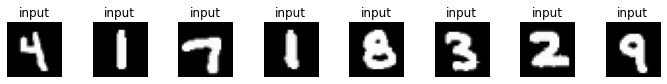

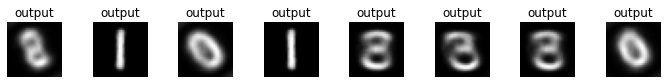

fold:1 epoch:21/50 [tra]loss:174.3426 [val]loss:174.6778 [time]total:5.53sec tra:2.97sec val:2.56sec
fold:1 epoch:22/50 [tra]loss:173.6754 [val]loss:171.4227 [time]total:5.45sec tra:2.93sec val:2.53sec
fold:1 epoch:23/50 [tra]loss:172.8234 [val]loss:171.6175 [time]total:5.50sec tra:2.97sec val:2.54sec
fold:1 epoch:24/50 [tra]loss:172.2161 [val]loss:170.2100 [time]total:5.50sec tra:2.93sec val:2.58sec
fold:1 epoch:25/50 [tra]loss:172.0921 [val]loss:170.3183 [time]total:5.48sec tra:2.95sec val:2.53sec
fold:1 epoch:26/50 [tra]loss:171.9669 [val]loss:170.1542 [time]total:5.51sec tra:2.97sec val:2.54sec
fold:1 epoch:27/50 [tra]loss:171.7584 [val]loss:168.9419 [time]total:5.78sec tra:3.01sec val:2.77sec
fold:1 epoch:28/50 [tra]loss:170.7732 [val]loss:168.0394 [time]total:5.32sec tra:2.98sec val:2.34sec
fold:1 epoch:29/50 [tra]loss:170.4644 [val]loss:167.0434 [time]total:5.71sec tra:2.97sec val:2.74sec
fold:1 epoch:30/50 [tra]loss:170.1542 [val]loss:167.3837 [time]total:5.35sec tra:2.98sec va

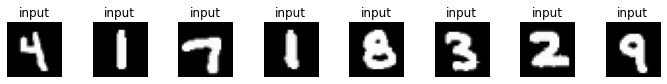

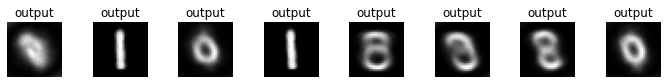

fold:1 epoch:31/50 [tra]loss:170.0632 [val]loss:166.6481 [time]total:5.40sec tra:2.96sec val:2.44sec
fold:1 epoch:32/50 [tra]loss:169.6052 [val]loss:164.8389 [time]total:5.40sec tra:2.97sec val:2.43sec
fold:1 epoch:33/50 [tra]loss:169.0821 [val]loss:165.9744 [time]total:5.83sec tra:2.99sec val:2.85sec
fold:1 epoch:34/50 [tra]loss:170.4259 [val]loss:165.7235 [time]total:5.51sec tra:3.03sec val:2.48sec
fold:1 epoch:35/50 [tra]loss:168.5668 [val]loss:165.1392 [time]total:5.67sec tra:3.01sec val:2.66sec
fold:1 epoch:36/50 [tra]loss:168.4425 [val]loss:165.3926 [time]total:5.35sec tra:2.95sec val:2.41sec
fold:1 epoch:37/50 [tra]loss:169.1047 [val]loss:164.0904 [time]total:5.55sec tra:2.95sec val:2.60sec
fold:1 epoch:38/50 [tra]loss:168.2759 [val]loss:164.3516 [time]total:5.66sec tra:3.02sec val:2.65sec
fold:1 epoch:39/50 [tra]loss:167.4871 [val]loss:164.0841 [time]total:5.35sec tra:2.95sec val:2.40sec
fold:1 epoch:40/50 [tra]loss:168.3288 [val]loss:165.5924 [time]total:5.50sec tra:2.92sec va

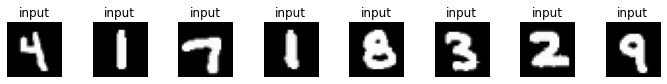

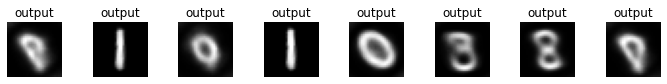

fold:1 epoch:41/50 [tra]loss:168.6035 [val]loss:162.8027 [time]total:5.64sec tra:2.98sec val:2.66sec
fold:1 epoch:42/50 [tra]loss:167.5448 [val]loss:163.7192 [time]total:5.37sec tra:2.99sec val:2.38sec
fold:1 epoch:43/50 [tra]loss:167.4402 [val]loss:163.2830 [time]total:5.71sec tra:2.99sec val:2.72sec
fold:1 epoch:44/50 [tra]loss:166.9059 [val]loss:162.1774 [time]total:5.65sec tra:2.99sec val:2.67sec
fold:1 epoch:45/50 [tra]loss:167.9499 [val]loss:163.2126 [time]total:5.43sec tra:3.01sec val:2.42sec
fold:1 epoch:46/50 [tra]loss:166.9384 [val]loss:162.3961 [time]total:5.57sec tra:2.98sec val:2.59sec
fold:1 epoch:47/50 [tra]loss:166.4752 [val]loss:163.0275 [time]total:5.57sec tra:2.97sec val:2.60sec
fold:1 epoch:48/50 [tra]loss:166.8281 [val]loss:160.6983 [time]total:5.34sec tra:2.95sec val:2.38sec
fold:1 epoch:49/50 [tra]loss:166.5392 [val]loss:161.5760 [time]total:5.73sec tra:2.97sec val:2.75sec
fold:1 epoch:50/50 [tra]loss:166.6541 [val]loss:160.2917 [time]total:5.32sec tra:2.95sec va

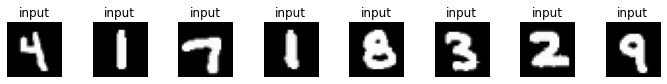

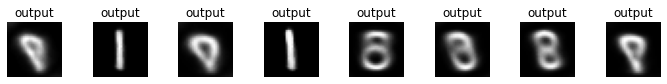

model saved to >> model_epoch50_StratifiedKFold_1_2.pth



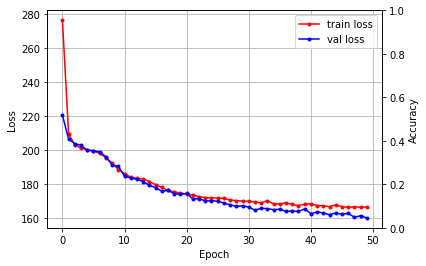

StratifiedKFold fold:2/2
train_N=30000, val_N=30000
fold:2 epoch:1/50 [tra]loss:268.1959 [val]loss:219.5702 [time]total:5.43sec tra:2.96sec val:2.47sec
fold:2 epoch:2/50 [tra]loss:209.0186 [val]loss:206.4731 [time]total:5.39sec tra:2.97sec val:2.42sec
fold:2 epoch:3/50 [tra]loss:202.4855 [val]loss:203.0083 [time]total:5.81sec tra:3.00sec val:2.81sec
fold:2 epoch:4/50 [tra]loss:201.2381 [val]loss:202.4363 [time]total:5.46sec tra:3.02sec val:2.45sec
fold:2 epoch:5/50 [tra]loss:200.3253 [val]loss:201.6343 [time]total:5.73sec tra:3.02sec val:2.71sec
fold:2 epoch:6/50 [tra]loss:195.8234 [val]loss:190.2706 [time]total:5.50sec tra:3.02sec val:2.48sec
fold:2 epoch:7/50 [tra]loss:187.3793 [val]loss:186.1545 [time]total:5.56sec tra:2.96sec val:2.60sec
fold:2 epoch:8/50 [tra]loss:185.3533 [val]loss:186.1676 [time]total:5.39sec tra:2.99sec val:2.40sec
fold:2 epoch:9/50 [tra]loss:184.5299 [val]loss:185.1747 [time]total:5.71sec tra:2.98sec val:2.73sec
fold:2 epoch:10/50 [tra]loss:183.8207 [val]loss:

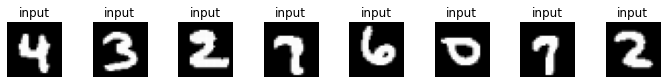

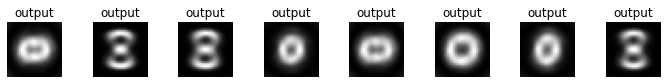

fold:2 epoch:11/50 [tra]loss:183.1392 [val]loss:183.4543 [time]total:5.58sec tra:3.04sec val:2.54sec
fold:2 epoch:12/50 [tra]loss:182.1904 [val]loss:182.6184 [time]total:5.41sec tra:3.01sec val:2.40sec
fold:2 epoch:13/50 [tra]loss:180.8774 [val]loss:179.5062 [time]total:5.79sec tra:2.97sec val:2.82sec
fold:2 epoch:14/50 [tra]loss:178.9339 [val]loss:178.4606 [time]total:5.44sec tra:2.99sec val:2.45sec
fold:2 epoch:15/50 [tra]loss:177.2122 [val]loss:176.0170 [time]total:5.59sec tra:2.97sec val:2.62sec
fold:2 epoch:16/50 [tra]loss:176.9135 [val]loss:174.8396 [time]total:5.39sec tra:2.97sec val:2.42sec
fold:2 epoch:17/50 [tra]loss:176.1738 [val]loss:174.8270 [time]total:5.60sec tra:2.98sec val:2.62sec
fold:2 epoch:18/50 [tra]loss:175.2301 [val]loss:174.4436 [time]total:5.62sec tra:2.97sec val:2.65sec
fold:2 epoch:19/50 [tra]loss:174.7744 [val]loss:172.6179 [time]total:5.45sec tra:2.99sec val:2.46sec
fold:2 epoch:20/50 [tra]loss:174.5323 [val]loss:172.9489 [time]total:5.65sec tra:3.00sec va

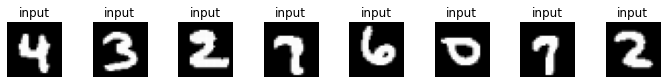

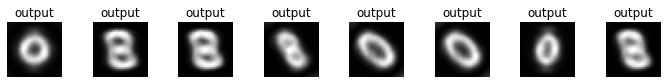

fold:2 epoch:21/50 [tra]loss:173.7988 [val]loss:172.9802 [time]total:5.69sec tra:3.01sec val:2.68sec
fold:2 epoch:22/50 [tra]loss:173.4100 [val]loss:172.5387 [time]total:5.39sec tra:2.95sec val:2.45sec
fold:2 epoch:23/50 [tra]loss:173.4807 [val]loss:172.4218 [time]total:5.37sec tra:2.99sec val:2.38sec
fold:2 epoch:24/50 [tra]loss:172.8930 [val]loss:173.6132 [time]total:5.71sec tra:2.96sec val:2.74sec
fold:2 epoch:25/50 [tra]loss:173.0418 [val]loss:175.2413 [time]total:5.33sec tra:2.95sec val:2.38sec
fold:2 epoch:26/50 [tra]loss:173.2366 [val]loss:171.2680 [time]total:5.68sec tra:2.95sec val:2.73sec
fold:2 epoch:27/50 [tra]loss:172.1533 [val]loss:173.4990 [time]total:5.63sec tra:2.97sec val:2.66sec
fold:2 epoch:28/50 [tra]loss:171.8239 [val]loss:170.3319 [time]total:5.42sec tra:2.95sec val:2.47sec
fold:2 epoch:29/50 [tra]loss:171.5747 [val]loss:170.2844 [time]total:5.39sec tra:3.01sec val:2.38sec
fold:2 epoch:30/50 [tra]loss:171.3972 [val]loss:170.2440 [time]total:5.71sec tra:2.97sec va

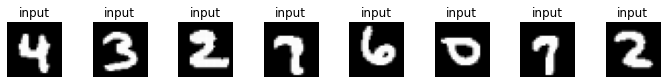

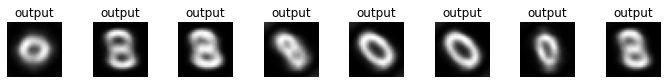

fold:2 epoch:31/50 [tra]loss:171.3545 [val]loss:166.8776 [time]total:5.61sec tra:2.93sec val:2.69sec
fold:2 epoch:32/50 [tra]loss:170.3682 [val]loss:167.1626 [time]total:5.38sec tra:2.94sec val:2.44sec
fold:2 epoch:33/50 [tra]loss:170.5428 [val]loss:166.7111 [time]total:5.64sec tra:3.00sec val:2.63sec
fold:2 epoch:34/50 [tra]loss:169.7620 [val]loss:166.2026 [time]total:5.39sec tra:3.00sec val:2.39sec
fold:2 epoch:35/50 [tra]loss:169.4930 [val]loss:166.6193 [time]total:5.80sec tra:3.00sec val:2.80sec
fold:2 epoch:36/50 [tra]loss:168.9518 [val]loss:166.3927 [time]total:5.38sec tra:2.98sec val:2.41sec
fold:2 epoch:37/50 [tra]loss:168.8156 [val]loss:163.8409 [time]total:5.54sec tra:2.94sec val:2.59sec
fold:2 epoch:38/50 [tra]loss:168.0308 [val]loss:163.9500 [time]total:5.59sec tra:2.98sec val:2.61sec
fold:2 epoch:39/50 [tra]loss:168.3229 [val]loss:163.1421 [time]total:5.51sec tra:3.03sec val:2.47sec
fold:2 epoch:40/50 [tra]loss:167.4162 [val]loss:163.0834 [time]total:5.81sec tra:3.03sec va

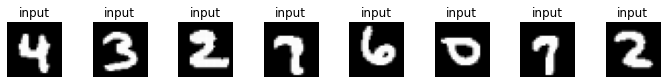

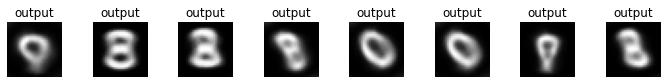

fold:2 epoch:41/50 [tra]loss:167.6489 [val]loss:165.0504 [time]total:5.66sec tra:3.00sec val:2.66sec
fold:2 epoch:42/50 [tra]loss:167.4746 [val]loss:163.5909 [time]total:5.35sec tra:2.94sec val:2.41sec
fold:2 epoch:43/50 [tra]loss:167.6614 [val]loss:161.2237 [time]total:5.55sec tra:2.96sec val:2.59sec
fold:2 epoch:44/50 [tra]loss:167.4691 [val]loss:165.8412 [time]total:5.64sec tra:2.97sec val:2.68sec
fold:2 epoch:45/50 [tra]loss:166.8391 [val]loss:162.0906 [time]total:5.46sec tra:3.01sec val:2.45sec
fold:2 epoch:46/50 [tra]loss:166.9473 [val]loss:160.4877 [time]total:5.59sec tra:2.97sec val:2.62sec
fold:2 epoch:47/50 [tra]loss:166.0957 [val]loss:160.2689 [time]total:5.42sec tra:3.04sec val:2.39sec
fold:2 epoch:48/50 [tra]loss:165.4720 [val]loss:158.7100 [time]total:5.79sec tra:2.99sec val:2.80sec
fold:2 epoch:49/50 [tra]loss:165.5097 [val]loss:160.8535 [time]total:5.46sec tra:3.03sec val:2.43sec
fold:2 epoch:50/50 [tra]loss:166.8329 [val]loss:159.6204 [time]total:5.86sec tra:3.02sec va

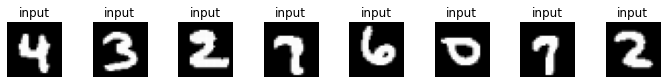

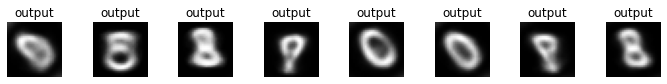

model saved to >> model_epoch50_StratifiedKFold_2_2.pth



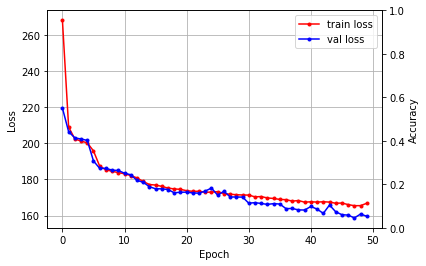

In [29]:
train_models, train_model_paths = train()

# Test

model 1


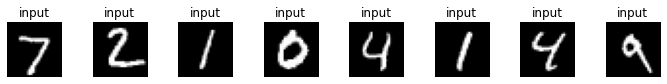

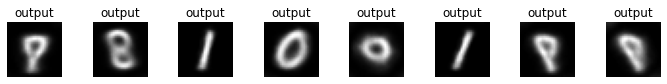

model 2


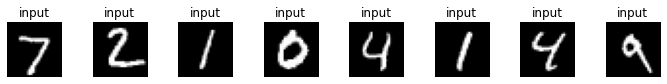

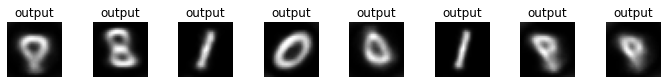

In [32]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    dataset_test = MnistDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            xs = batch[0].to(device) # image
            ys = batch[1]

            for i, model in enumerate(train_models):
                outputs, mu, sigma = model(xs)

                print(f"model {i + 1}")
                show_sample(xs, name="input")
                show_sample(outputs, name="output")

            break

test(train_models)

# Latent Space

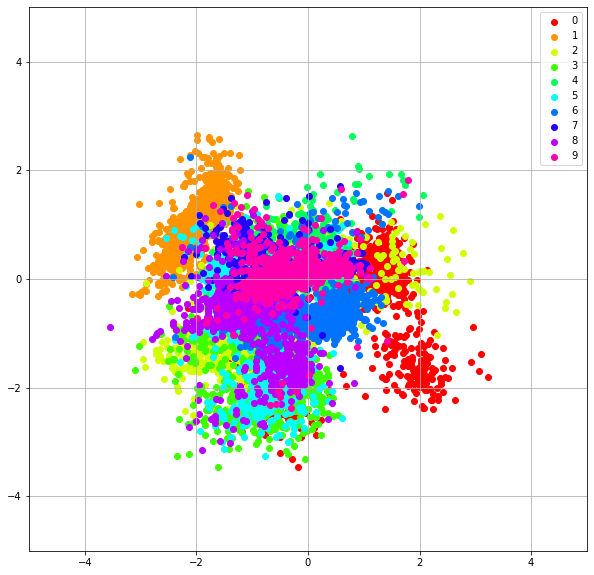

In [35]:
import matplotlib.cm

def latent_show(train_models):
    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    plt.figure(figsize=[10, 10])
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    
    colors = np.array([matplotlib.cm.hsv(i / 10) for i in range(10)])

    with torch.no_grad():
        model = train_models[0]
        model.eval()

        for class_i in range(10):
            _test_xs = test_Xs[test_ys == class_i]
            _test_ys = test_ys[test_ys == class_i]

            dataset_test = MnistDataset(_test_xs, _test_ys, transforms=transforms_val)
            dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

            z1 = np.ndarray(shape=[0])
            z2 = np.ndarray(shape=[0])

            for step, batch in enumerate(dataloader_test):
                xs = batch[0].to(device) # image
                ys = batch[1]

                z = model.sample_z(xs)

                z = z.detach().cpu().numpy()
            
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    plt.grid()
    plt.legend()
    plt.show()
    
latent_show(train_models)

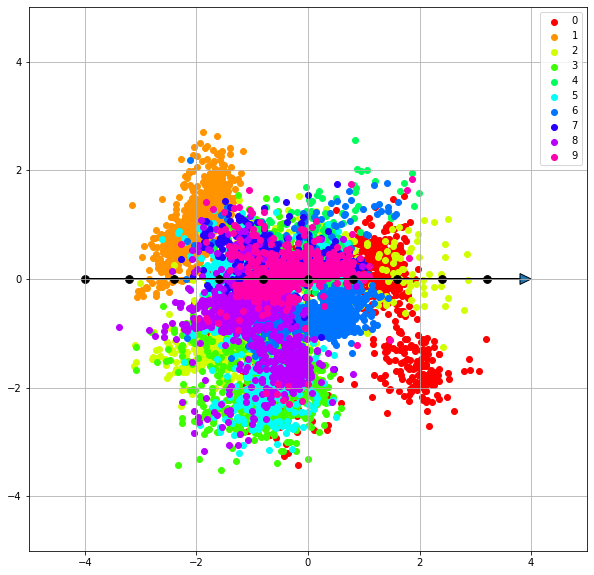

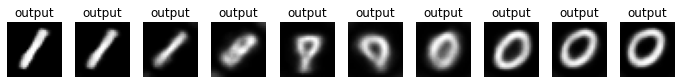

In [59]:
def latent_control(train_models, show_num=10):

    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    plt.figure(figsize=[10, 10])
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])

    # latent lower and upper bound
    z1_lower, z1_upper = -4, 4
    z2_lower, z2_upper = 0, 0

    div1 = (z1_upper - z1_lower) / show_num
    div2 = (z2_upper - z2_lower) / show_num
    
    zs1 = np.array([z1_lower + div1 * i for i in range(show_num)])
    zs2 = np.array([z2_lower + div2 * i for i in range(show_num)])
    
    colors = np.array([matplotlib.cm.hsv(i / 10) for i in range(10)])
    
    with torch.no_grad():
        model = train_models[0]
        model.eval()

        for class_i in range(10):
            _test_xs = test_Xs[test_ys == class_i]
            _test_ys = test_ys[test_ys == class_i]

            dataset_test = MnistDataset(_test_xs, _test_ys, transforms=transforms_val)
            dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

            z1 = np.ndarray(shape=[0])
            z2 = np.ndarray(shape=[0])

            for step, batch in enumerate(dataloader_test):
                xs = batch[0].to(device) # image
                ys = batch[1]

                z = model.sample_z(xs)

                z = z.detach().cpu().numpy()
            
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    # draw sampling position
    plt.arrow(z1_lower, z2_lower, z1_upper - z1_lower, z2_upper - z2_lower, length_includes_head=True,
          head_width=0.2, head_length=0.2)
    plt.scatter(zs1, zs2, color='black', s=60)
    plt.grid()
    plt.legend()
    plt.show()
    
    # decode latent vector
    with torch.no_grad():
        zs = [zs1, zs2]
        zs = torch.tensor(zs, dtype=torch.float).to(device).T
        outputs = model.forward_decoder(zs)
        show_sample(outputs, name="output", show_num=show_num)
    
latent_control(train_models)

# VAE + KMeans

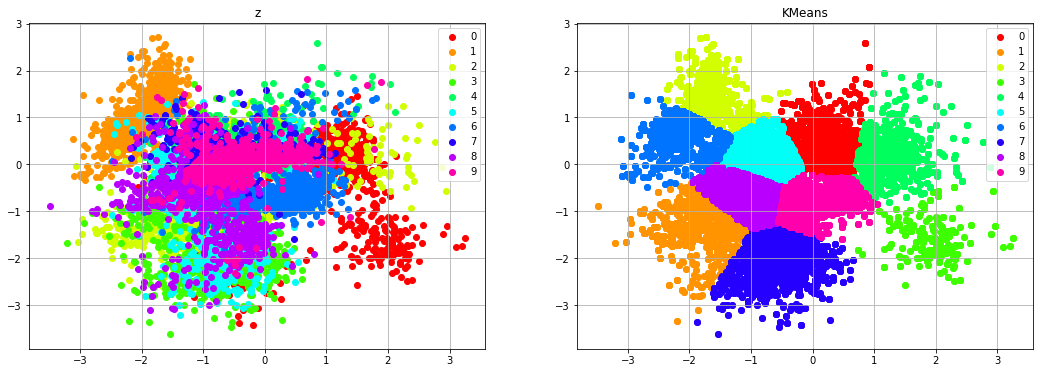

In [65]:
from sklearn.cluster import KMeans

def latent_kmeans(train_models):
    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    colors = np.array([matplotlib.cm.hsv(i / 10) for i in range(10)])

    z1_all = np.ndarray(shape=1)
    z2_all = np.ndarray(shape=1)
    ts = np.ndarray(shape=1)
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title('z')
    
    with torch.no_grad():
        model = train_models[0]
        model.eval()

        for class_i in range(10):
            _test_xs = test_Xs[test_ys == class_i]
            _test_ys = test_ys[test_ys == class_i]

            dataset_test = MnistDataset(_test_xs, _test_ys, transforms=transforms_val)
            dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

            z1 = np.ndarray(shape=[0])
            z2 = np.ndarray(shape=[0])

            for step, batch in enumerate(dataloader_test):
                xs = batch[0].to(device) # image
                ys = batch[1]

                z = model.sample_z(xs)

                z = z.detach().cpu().numpy()
            
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

                z1_all = np.append(z1_all, z1)
                z2_all = np.append(z2_all, z2)
            
                z1_all = np.append(z1_all, z1)
                z2_all = np.append(z2_all, z2)
                ts = np.append(ts, [class_i] * len(z1))

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)

    #---
    # KMeans
    #---
    clf = KMeans(n_clusters=10, random_state=0)
    kmeans = clf.fit(np.array([z1_all, z2_all]).T)
    ys = kmeans.labels_
    
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('KMeans')
    for i in range(10):
        _z1 = z1_all[ys == i]
        _z2 = z2_all[ys == i]
        plt.scatter(_z1, _z2, c=[colors[i]], label=i)
        
    plt.grid()
    plt.legend()
    plt.show()
    
latent_kmeans(train_models)